In [26]:
import tensorflow as tf
from tensorflow.keras import models, layers, Sequential
import matplotlib.pyplot as plt
from IPython.display import HTML

In [6]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [7]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Potato Dataset",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [9]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [10]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


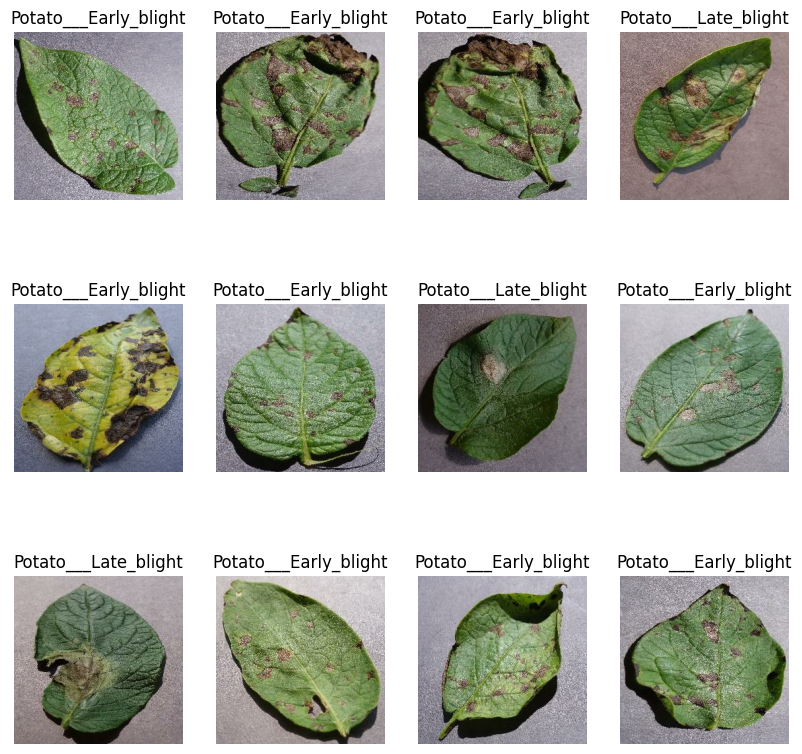

In [11]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [12]:
len(dataset)

68

In [13]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [14]:
train_ds = dataset.take(54)
len(train_ds)

54

In [15]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [16]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [17]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [18]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [19]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [20]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [21]:
len(train_ds)

54

In [22]:
len(val_ds)

6

In [23]:
len(test_ds)

8

In [24]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [29]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.Rescaling(1./255),
])

In [31]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [32]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [34]:
model = Sequential([
    layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),  # Input layer
    resize_and_rescale,
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

# Check model summary
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 60, 60, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 28, 28, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 12, 12, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 4, 4, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 2, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [35]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [36]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.4195 - loss: 0.9406 - val_accuracy: 0.5312 - val_loss: 0.8277
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.6143 - loss: 0.7823 - val_accuracy: 0.6719 - val_loss: 0.6827
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.7647 - loss: 0.5624 - val_accuracy: 0.5833 - val_loss: 1.2332
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.7581 - loss: 0.6154 - val_accuracy: 0.8333 - val_loss: 0.5712
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.8753 - loss: 0.3515 - val_accuracy: 0.8542 - val_loss: 0.3179
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.9043 - loss: 0.2478 - val_accuracy: 0.8281 - val_loss: 0.4521
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.8663 - loss: 0.3913 - val_accuracy: 0.8542 - val_loss: 0.3518
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.9248 - loss: 0.2045 - val_accuracy: 0.8958 - val_loss

In [38]:
model.save('my_model.keras')


In [67]:
from tensorflow.keras.models import load_model

# Load the model without the optimizer state
model = load_model('my_model.keras', compile=False)

# Compile the model with the desired optimizer and loss function
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])



In [68]:
from tensorflow.keras.models import load_model

# Load the model without the optimizer state
model = load_model('my_model.keras', compile=False)

# Compile the model with the desired optimizer and loss function
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])


In [69]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

BATCH_SIZE = 32
IMAGE_SIZE = 256

# Load the dataset with categorical labels
dataset = image_dataset_from_directory(
    "Potato Dataset",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='categorical'  # Automatically one-hot encode labels
)

# Check the class names
class_names = dataset.class_names
print("Class names:", class_names)

# Load the model
from tensorflow.keras.models import load_model
model = load_model('my_model.keras', compile=False)

# Recompile the model with optimizer and loss function
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

# Evaluate the model
scores = model.evaluate(dataset)  # Pass the dataset directly
print(f"Test accuracy: {scores[1]}")


Found 2152 files belonging to 3 classes.
Class names: ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']
68/68 ━━━━━━━━━━━━━━━━━━━━ 19s 255ms/step - accuracy: 0.9646 - loss: 0.1054
Test accuracy: 0.9632899761199951


In [70]:
scores

[0.10348223149776459, 0.9632899761199951]

In [71]:
history

In [72]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [73]:
type(history.history['loss'])

list

In [74]:
len(history.history['loss'])

50

In [75]:
history.history['loss'][:5] # show loss for first 5 epoch

[0.8914132714271545,
 0.731139600276947,
 0.49280840158462524,
 0.49302011728286743,
 0.36222097277641296]

In [76]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

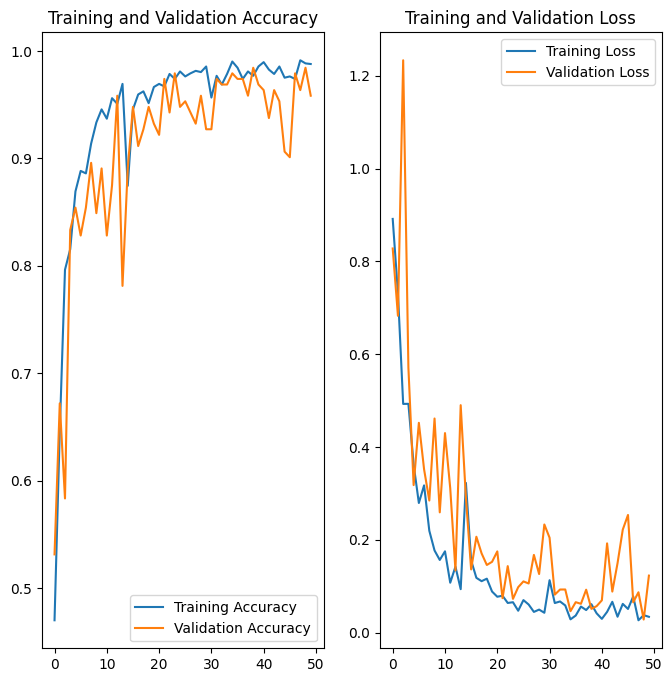

In [77]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step
predicted label: Potato___Late_blight


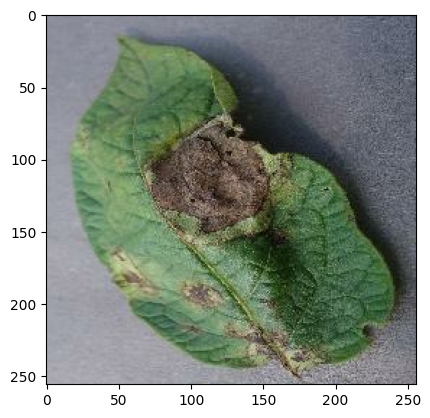

In [78]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [79]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


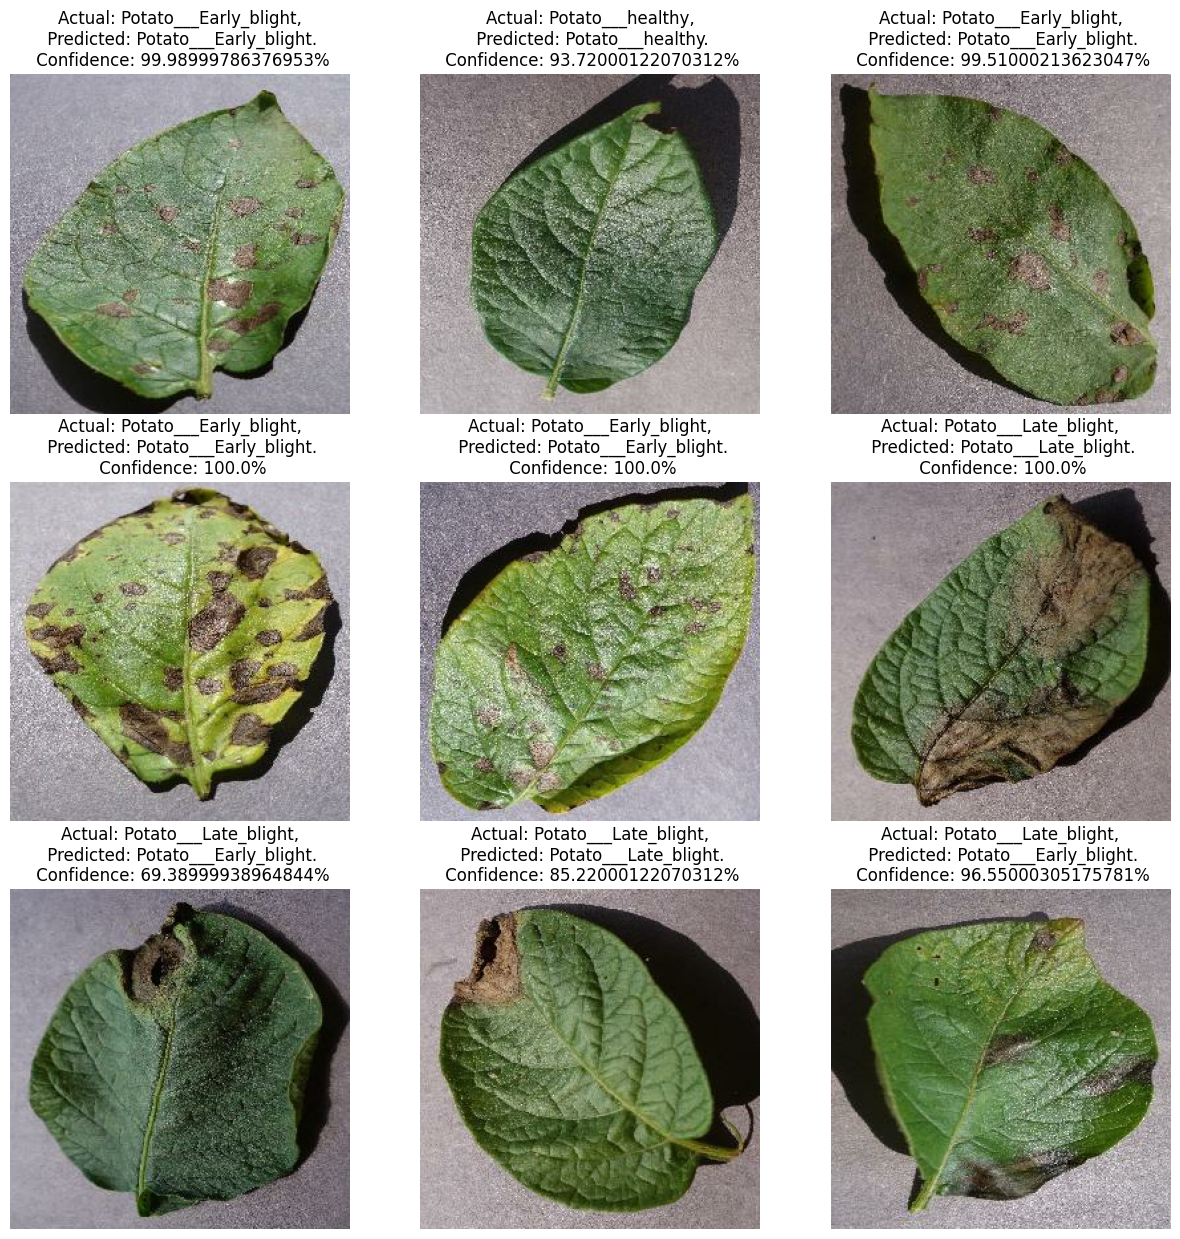

In [80]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [66]:
import os

# Create the models directory if it doesn't exist
models_dir = "../models"
os.makedirs(models_dir, exist_ok=True)

# Save the model with versioning
model_version = max([int(i) for i in os.listdir(models_dir) if i.isdigit()] + [0]) + 1
model.save(f"{models_dir}/{model_version}.keras")  # Use `.keras` extension

# Save the model with a static name
model.save("../potatoes.h5")  # Static save with `.h5`
